In [3]:
import utils
from IPython.display import Image as DisImage
import os
import cv2
import math
import numpy as np
from scipy.ndimage.filters import maximum_filter, minimum_filter

now_path = os.path.abspath(os.getcwd())

C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_41316\2335930660.py:7: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_41316\2335930660.py:7: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


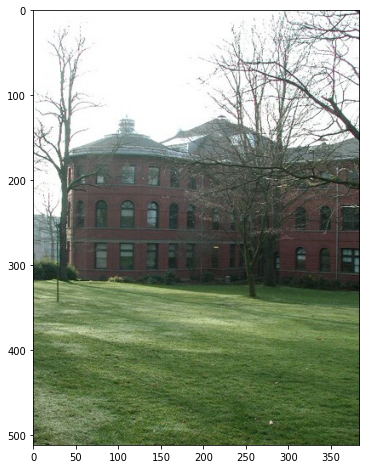

In [4]:
imgs = []
imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/parrington/prtn00.jpg')))
# imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/test/0test.jpg')))

utils.imshow_plt(imgs[0])

In [5]:
def to_gaussian_list(img, s = 5, sigma = 1.6, input_blur = 0.5, interval_count = 3, plt_img = False):
    height, width, _ = img.shape
    std_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    std_img = cv2.resize(std_img, (width * 2, height * 2), cv2.INTER_LINEAR)
    # σ² = σ₁² + σ₂²
    sigma_diff = math.sqrt(max(0.01, sigma ** 2 - ((input_blur * 2) ** 2)))
    # Anti alias
    std_img = cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma_diff)
    octave_count = int(math.log2(min(width, height)) - 1)
    # 2 extra LoGs because we cant scan top and bottom layers
    img_count_perOctave = s + 3
    print(octave_count)
    DoGOctaves = []
    GaussianOctaves = []
    k = 2 ** (1 / s)

    for i in range(octave_count):
        gaussian_imgs = []
        gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma))
        # octave
        for j in range(1, img_count_perOctave):
            gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=(sigma * (k ** j))))
            print("Sigma:", sigma * (k ** j))
        GaussianOctaves.append(gaussian_imgs)
        DoGs = []
        for j in range(img_count_perOctave - 1):
            # DoGs.append(cv2.subtract(gaussian_imgs[j], gaussian_imgs[j + 1]))
            DoGs.append(gaussian_imgs[j].astype('float32') - gaussian_imgs[j + 1].astype('float32'))
        DoGOctaves.append(DoGs)
        # scale down image to speed up process
        std_img = cv2.resize(gaussian_imgs[-3], (width // (2 ** i), height // (2 ** i)))
        # sigma *= 2
        if plt_img:
            utils.imshows_plt(gaussian_imgs)
            utils.imshows_plt(DoGs)

    return DoGOctaves, GaussianOctaves
    

In [6]:
# DoGOctaves
"""
Octaves
[
    DoG Collection
    [
        DoG
    ]
]
"""

# GaussianOctaves
"""
GaussianOctaves
[
    Gaussians
    [
        
    ]
]
"""

'\nGaussianOctaves\n[\n    Gaussians\n    [\n        \n    ]\n]\n'

In [7]:
# to_gaussian_list(imgs[0], plt_img=True)

In [8]:
# def findMaxAndMinIn3x3x3(DoGs, DoGId, row, col):
#     for i in ra
#     maxVal = max(DoGs[DoGId][row][col], DoGs[DoGId][row][col], DoGs[DoGId][row][col])


In [9]:
DoGOctaves, GaussianOctaves = to_gaussian_list(imgs[0])

7
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985


In [10]:
def findExtremaInDoG(Octaves, OctaveLayersCount = 5, contrastThreshold = 0.4):
    # DoGOctaves
    """
    Octaves
    [
        DoGOctave
        [
            DoG
        ]
    ]
    """
    candidates = []
    # height, width = DoGs[0].shape
    for OctaveIdx in range(len(Octaves)):
        DoGOctave = Octaves[OctaveIdx]
        maxConv = DoGOctave * (DoGOctave == maximum_filter(DoGOctave,footprint=np.ones((3,3,3))))
        minConv = DoGOctave * (DoGOctave == minimum_filter(DoGOctave,footprint=np.ones((3,3,3))))

        utils.imshow_plt(maxConv[0])
        threshold = int(0.5 * contrastThreshold / (OctaveLayersCount + 3) * 255)
        maxConvInds = np.argwhere(maxConv > threshold)
        minConvInds = np.argwhere(minConv < -threshold)

        print("Max len:", len(maxConvInds))
        print("min len:", len(minConvInds))

        print(np.array(maxConvInds))

        candidates.extend(maxConvInds)
        candidates.extend(minConvInds)

    print("Extrema length:", len(candidates), candidates[0])

    keypoints = []
    # keypoint_dict = {}
    for candidate in candidates:
        # keypoints.append(cv2.KeyPoint(float(candidate[2]), float(candidate[1]), 1))
        # keypoint [row, col, sigma_index]
        keypoints.append([int(candidate[1]), int(candidate[2]), int(candidate[0])])
        # keypoint_dict[(candidate[2], candidate[1])] = 1
            # keypoints.append([candidate[1], candidate[2]])
    # print(len(keypoint_dict))
    return keypoints

    

    
    

In [11]:
def get_parameters(D, row, col, sigma):
    """_summary_

    Args:
        D (list): octaves
        row (int): x of image
        col (int): y of image
        sigma (int): Index of image in a octave

    Returns:
        extremum: np.array(3)
        hessianXY: np.array((2, 2))
        gradient: np.array(3)
    """
    dx = (D[sigma][row, col + 1] - D[sigma][row, col - 1]) / 2.0
    dy = (D[sigma][row + 1, col] - D[sigma][row - 1, col]) / 2.0
    ds = (D[sigma + 1][row, col] - D[sigma - 1][row, col]) / 2.0

    dxx = D[sigma][row, col + 1] - 2 * D[sigma][row, col] + D[sigma][row, col - 1]
    dyy = D[sigma][row + 1, col] - 2 * D[sigma][row, col] + D[sigma][row - 1, col]
    dss = D[sigma + 1][row, col] - 2 * D[sigma][row, col] + D[sigma - 1][row, col]

    dxy = (D[sigma][row + 1, col + 1] - D[sigma][row + 1, col - 1] - D[sigma][row - 1, col + 1] + D[sigma][row - 1, col - 1]) / 4.0
    dxs = (D[sigma + 1][row, col + 1] - D[sigma + 1][row, col - 1] - D[sigma - 1][row, col + 1] + D[sigma - 1][row, col - 1]) / 4.0
    dys = (D[sigma + 1][row + 1, col] - D[sigma + 1][row - 1, col] - D[sigma - 1][row + 1, col] + D[sigma - 1][row - 1, col]) / 4.0

    gradient = np.array([dx, dy, ds])
    hessian = np.array([
                            [dxx, dxy, dxs],
                            [dxy, dyy, dys],
                            [dxs, dys, dss]
                        ])
    hessianXY = np.array([
                            [dxx, dxy],
                            [dxy, dyy]
                        ])

    extremum = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]

    if abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        return None

    return extremum, hessianXY, gradient

    

In [12]:
def findScaleSpaceExtrema(DoGs, row, col, sigma_idx):
    height, width = DoGs[sigma_idx].shape
    sigma_size = len(DoGs)
    if row < 1 or row >= height - 1 or col < 1 or col >= width - 1 or sigma_idx < 1 or sigma_idx >= sigma_size - 1:
        return None
    var = get_parameters(DoGs, row, col, sigma_idx)
    if var is None:
        return None
    extremum, hessianXY, gradient = var
    iter_count = 0
    while abs(extremum[0]) > 0.5 or abs(extremum[1]) > 0.5 or abs(extremum[2]) > 0.5:
        # Offset larger than 0.5, its the point nearby
        row, col, sigma_idx = round(extremum[0]) + row, round(extremum[1]) + col, round(extremum[2]) + sigma_idx
        # Check boundry
        if row < 0 or row >= height or col < 0 or col >= width or sigma_idx < 0 or sigma_idx >= sigma_size:
            break
        var = get_parameters(DoGs, row, col, sigma_idx)
        if var is None:
            return None
        extremum, hessianXY, gradient = var
        iter_count += 1
        if iter_count > 3:
            print("WARNING!!! iteration count is", iter_count)
    contrast = abs(DoGs[sigma_idx][row, col]) + 0.5 * np.dot(gradient, extremum)
    if contrast < 0.03:
        # Contrast too low
        return None

    tr = np.trace(hessianXY)
    det = np.linalg.det(hessianXY)

    r = 10.0
    if (((r + 1) ** 2) * det) < ((tr ** 2) * r):
        # Discard edge response
        return None
        
    return row, col, sigma_idx


    

In [17]:
def get_gradients(octaves):
    magOctaves = []
    sitaOctaves = []
    for octave in octaves:
        magnitudes = []
        sitas = []
        for img in octave:
            dx = np.gradient(img, axis=0) * 2
            dy = np.gradient(img, axis=1) * 2
            magnitudes.append(np.sqrt(np.square(dx) + np.square(dy)))
            sitas.append(np.arctan2(dy, dx))
        magOctaves.append(magnitudes)
        sitaOctaves.append(sitas)
    return magOctaves, sitaOctaves

In [14]:
def get_orientation(row, col, sigma_idx, GaussianImgs):
    
    pass

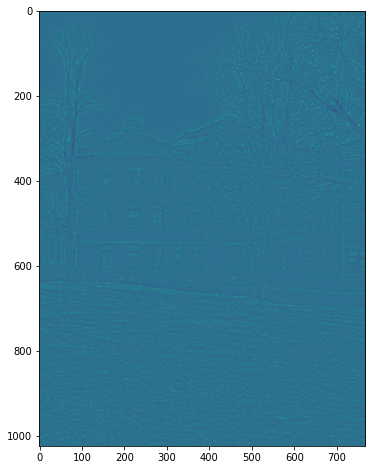

Max len: 437
min len: 857
[[  0 201 643]
 [  1   0 767]
 [  1 220 696]
 ...
 [  6 484  60]
 [  6 970 558]
 [  6 972 558]]


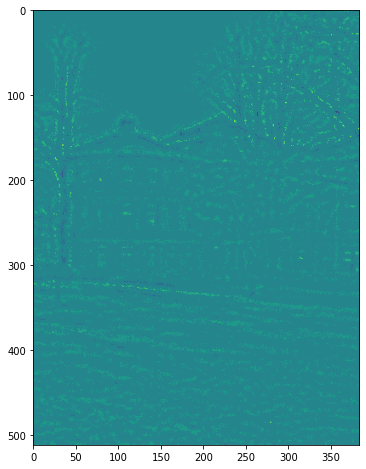

Max len: 44
min len: 98
[[  2 138 383]
 [  2 147 371]
 [  2 147 372]
 [  2 147 373]
 [  2 148 372]
 [  2 148 373]
 [  4 137 382]
 [  4 137 383]
 [  4 138 382]
 [  4 138 383]
 [  4 139 383]
 [  4 147 370]
 [  4 147 371]
 [  4 147 372]
 [  4 148 371]
 [  4 148 372]
 [  4 148 373]
 [  4 149 372]
 [  5 135 383]
 [  5 147 371]
 [  5 148 370]
 [  5 148 371]
 [  5 238  28]
 [  5 239  28]
 [  5 241  28]
 [  6 132 252]
 [  6 132 253]
 [  6 133 253]
 [  6 134 383]
 [  6 135 381]
 [  6 135 382]
 [  6 135 383]
 [  6 137 383]
 [  6 148 368]
 [  6 148 370]
 [  6 148 372]
 [  6 149 368]
 [  6 235  28]
 [  6 237  28]
 [  6 237  30]
 [  6 238  30]
 [  6 239  27]
 [  6 241  27]
 [  6 241  29]]


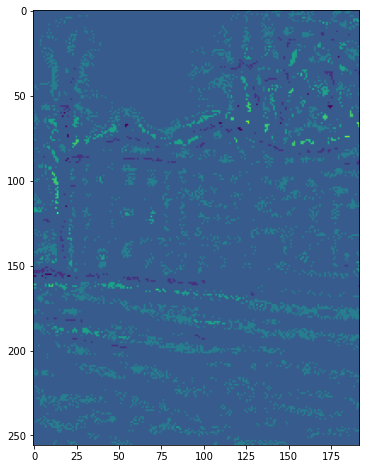

Max len: 0
min len: 5
[]


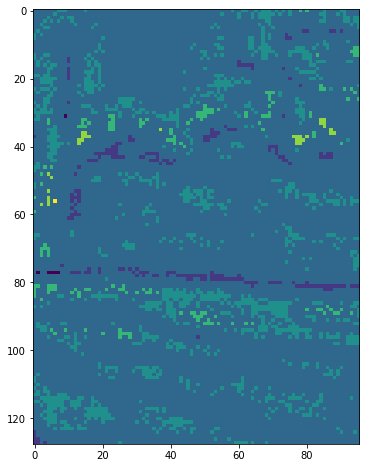

Max len: 24
min len: 0
[[ 6 50  0]
 [ 6 51  1]
 [ 6 51  2]
 [ 6 52  0]
 [ 6 52  1]
 [ 6 52  2]
 [ 6 52  3]
 [ 6 53  3]
 [ 6 53  4]
 [ 6 54  0]
 [ 6 54  1]
 [ 6 54  3]
 [ 6 54  4]
 [ 6 55  3]
 [ 6 55  4]
 [ 6 55  5]
 [ 6 56  0]
 [ 6 56  1]
 [ 6 56  2]
 [ 6 56  3]
 [ 6 56  4]
 [ 6 57  0]
 [ 6 57  1]
 [ 6 57  2]]


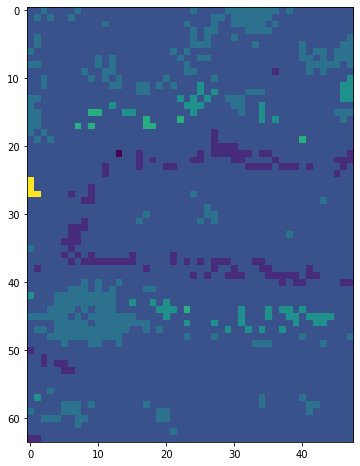

Max len: 18
min len: 0
[[ 3 26  0]
 [ 3 27  0]
 [ 4 25  0]
 [ 4 25  1]
 [ 4 26  0]
 [ 4 26  1]
 [ 4 27  0]
 [ 4 27  1]
 [ 4 28  0]
 [ 5 26  0]
 [ 5 26  1]
 [ 5 27  0]
 [ 5 27  1]
 [ 5 28  0]
 [ 5 28  1]
 [ 6 24  0]
 [ 6 26  0]
 [ 6 27  0]]


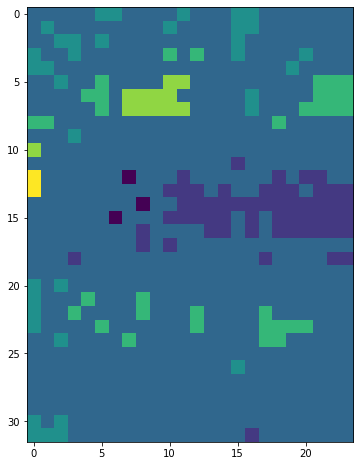

Max len: 0
min len: 0
[]


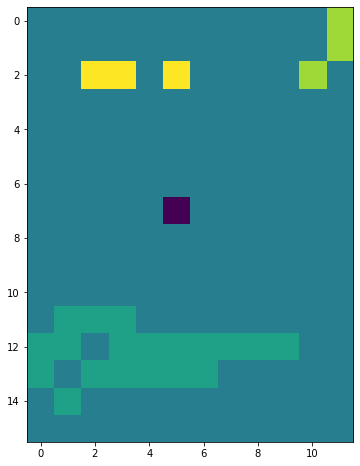

Max len: 12
min len: 0
[[ 5  0  3]
 [ 5  0  8]
 [ 6  0  0]
 [ 6  0  1]
 [ 6  0  3]
 [ 6  0  4]
 [ 6  0  5]
 [ 6  0  8]
 [ 6  0 10]
 [ 6  1  1]
 [ 6  1  3]
 [ 6  1  4]]
Extrema length: 1495 [  0 201 643]
Discarded points : 1185


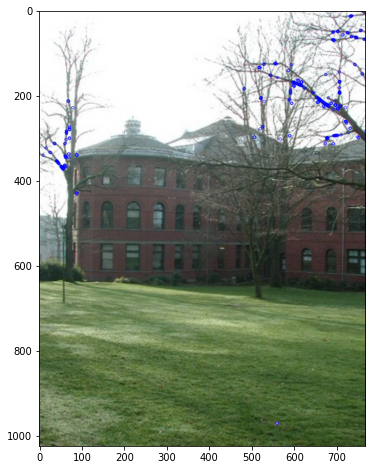

In [15]:
keypoints = findExtremaInDoG(DoGOctaves)
cv_keypoints = []
keypoint_dict = {}
discard_pnts_count = 0
for keypoint in keypoints:
    var = findScaleSpaceExtrema(DoGOctaves[0], keypoint[0], keypoint[1], keypoint[2])
    if var is not None:
        row, col, sigma_idx = var
        if (row, col) not in keypoint_dict:
            cv_keypoints.append(cv2.KeyPoint(col, row, 1))
            keypoint_dict[(row, col)] = 1
    else:
        discard_pnts_count += 1

print("Discarded points :", discard_pnts_count)


im_key = cv2.drawKeypoints(cv2.resize(imgs[0], (imgs[0].shape[1] * 2, imgs[0].shape[0] * 2)), cv_keypoints, np.array([]), (255, 0, 0))
# im_key = cv2.drawKeypoints(imgs, cv_keypoints, np.array([]), (255, 0, 0))

utils.imshow_plt(im_key)

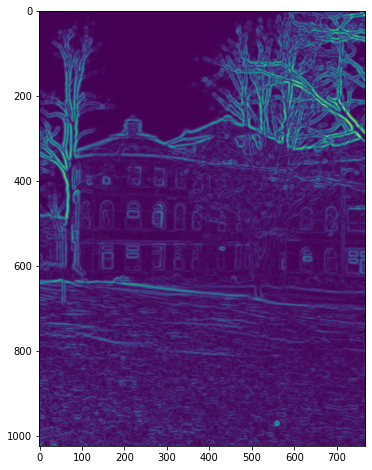

In [18]:
magOctaves, sitaOctaves = get_gradients(GaussianOctaves)
